# Random Forest Classifier

In [206]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.feature_extraction import text

from sklearn.pipeline import make_pipeline

from yellowbrick.classifier import ROCAUC, ClassificationReport, ClassPredictionError, ConfusionMatrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [207]:
# Reading in data
df = pd.read_csv('./data/processed_posts.csv')

In [208]:
# Potential stop words from notebook 4.2
my_stop_words = text.ENGLISH_STOP_WORDS.union(['http', 'com'])

In [209]:
# Creating X and y
X = df['lem_all_text']
y = df['subreddit']

In [210]:
# Tried both CountVectorizer and TfidfVectorizer. Tfidf worked best
tvect = TfidfVectorizer(stop_words = my_stop_words)
X_tvect = tvect.fit_transform(X)

/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amp'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [211]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_tvect, y, stratify=y, test_size=.2, random_state=23)


In [212]:
# Instantiating, fitting and scoring a Random Forest
forest = RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_features='auto',
)
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=500)

In [213]:
test_preds = forest.predict(X_test)
train_preds = forest.predict(X_train)

In [214]:
print(f' Training Accuracy: {forest.score(X_train, y_train)}')
print(f' Test Accuracy: {forest.score(X_test, y_test)}')
print(f' Training f1: {f1_score(y_train, train_preds)}')
print(f' Test f1: {f1_score(y_test, test_preds)}')

 Training Accuracy: 0.9851190476190477
 Test Accuracy: 0.8500886300329197
 Training f1: 0.9849888214627913
 Test f1: 0.8498224251648909


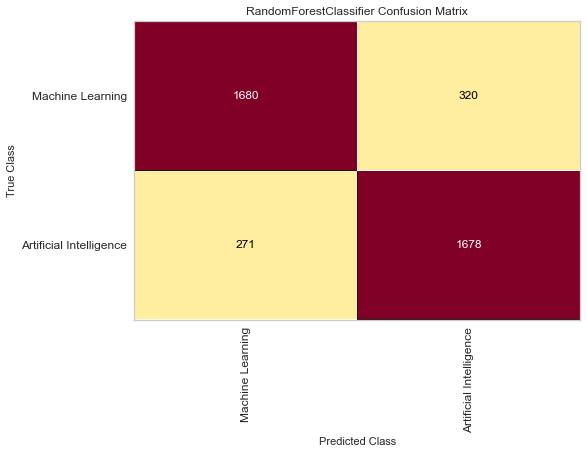

In [162]:
# Viewing a confusion matrix for the model
cm = ConfusionMatrix(forest, classes=['Machine Learning', 'Artificial Intelligence'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show(outpath='./assets/forest_cm.png');

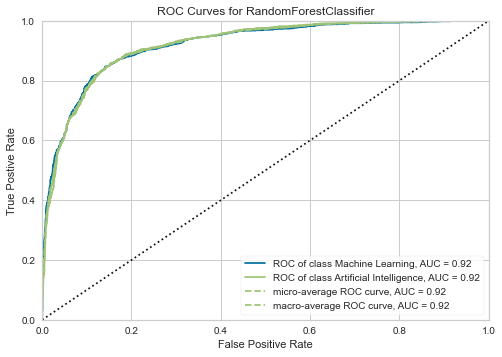

In [163]:
# Displaying the ROCAUC graph
roc = ROCAUC(forest, classes=['Machine Learning', 'Artificial Intelligence'])
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show(outpath='./assets/forest_rocauc.png');

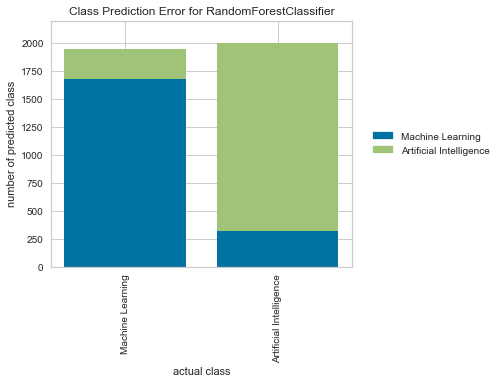

In [164]:
# We can see that we are incorrectly classifying ML posts as AI more often.
cpe = ClassPredictionError(forest, classes=['Machine Learning', 'Artificial Intelligence'])
cpe.fit(X_train, X_test)
cpe.score(X_test, y_test)
cpe.show(outpath='./assets/forest_cpe.png');

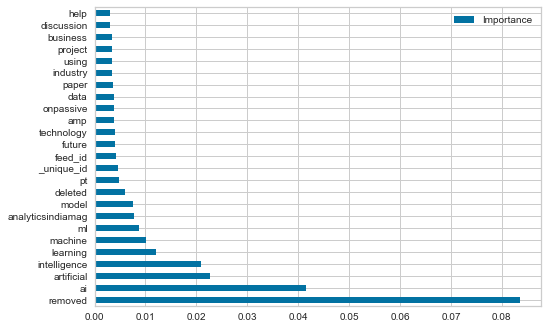

In [216]:
# Checking the most important features in the model.
pd.DataFrame(forest.feature_importances_, tvect.get_feature_names(), columns=['Importance']).sort_values('Importance', ascending=False).head(25).plot(kind='barh');
plt.savefig('./assets/forest_features.png')

### Pipeline and Gridsearch

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=23)

In [104]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

I have tested many different hyper parameters and found that these are the few that mattered the most. I have narrowed down the parameters to help the grid search complete faster.

In [110]:
params = {
    'tfidfvectorizer__stop_words': ['english'],
    'tfidfvectorizer__max_features': [9500, 9000, 9250],
    'tfidfvectorizer__min_df': [1, 3],
    'tfidfvectorizer__ngram_range': [(1, 1)],
    'randomforestclassifier__n_estimators': [100, 150, 250],
    'randomforestclassifier__criterion': ['entropy']
}

In [111]:
gs = GridSearchCV(pipe, params, n_jobs=-1, cv=10)

In [112]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['entropy'],
                         'randomforestclassifier__n_estimators': [250, 350,
                                                                  500],
                         'tfidfvectorizer__max_features': [9500, 9000, 12000],
                         'tfidfvectorizer__min_df': [1],
                         'tfidfvectorizer__ngram_range': [(1, 1)],
                         'tfidfvectorizer__stop_words': ['english']})

In [113]:
gs.best_params_

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__n_estimators': 250,
 'tfidfvectorizer__max_features': 9500,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english'}

In [114]:
gs.score(X_test, y_test)

0.8419773095623987

## Current best params:

In [92]:
gs.best_params_

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__n_estimators': 150,
 'tfidfvectorizer__max_features': 9000,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english'}

In [93]:
gs.score(X_test, y_test)

0.8517017828200972

## Scratch work below

The work below explores different models. Ultimately, I decided to work with the Random Forest Classifier described above. 

In [61]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [53]:
gboost = GradientBoostingClassifier()

In [54]:
gboost.fit(X_train, y_train)

GradientBoostingClassifier()

In [55]:
gboost.score(X_test, y_test)

0.710291734197731

In [58]:
ada = AdaBoostClassifier()

In [59]:
ada.fit(X_train , y_train)

AdaBoostClassifier()

In [60]:
ada.score(X_test, y_test)

0.690032414910859

In [62]:
lr = LogisticRegression()

In [63]:
lr.fit(X_train, y_train)

LogisticRegression()

In [64]:
lr.score(X_train, y_train)

0.8718000675447484

In [ ]:
LogisticRegression()

In [92]:
pipe2 = make_pipeline(TfidfVectorizer(), LogisticRegression())

In [94]:
params2 = params = {
    'tfidfvectorizer__ngram_range': [(1, 1), (2, 2)],
    'tfidfvectorizer__max_features': [100, 500, None],
    'tfidfvectorizer__stop_words': ['english', my_stop_words],
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': [.01, 1, 100],
    'logisticregression__max_iter': [4000]
}

In [95]:
gs2 = GridSearchCV(pipe2, params2, n_jobs=-1)

In [97]:
gs2.fit(X_train, y_train)

/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 1, 100],
                         'logisticregression__max_iter': [4000],
                         'logisticregression__penalty': ['l2'],
                         'tfidfvectorizer__max_features': [100, 500, None],
                         'tfidfvectorizer__ngram_range': [(1, 1), (2, 2)],
                         'tfidfvectorizer__stop_words': ['english',
                                                         frozenset({'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                   

In [98]:
gs2.best_params_

{'logisticregression__C': 1,
 'logisticregression__max_iter': 4000,
 'logisticregression__penalty': 'l2',
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__stop_words': 'english'}

In [99]:
# Logistic Regression did fairly well!
gs2.score(X_test, y_test)

0.8446110210696921